In [1]:
import pymecht as pmt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import sys
import os
sys.path.append(os.path.abspath("/home/shiting/code/closed-loop/closed_circuit"))
from compartments import *
from p_tqdm import p_map
def model(param):
    Emax_rv, Emin_rv = param, 0.04
    rv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax =Emax_rv, Emin = Emin_rv, V0 = 10, T = T, deltat = t_step)
    def dydt(t,y):
        v_lv = y[0]
        v_la = y[1]
        q_av = y[2]
        q_mv = y[3]
        xi_av = y[4]
        xi_mv = y[5]
        #pressure of capillaries in systemic circulation
        pa = y[6]
        v_rv = y[7]
        v_ra = y[8]
        q_tv = y[9]
        q_pv = y[10]
        xi_tv = y[11]
        xi_pv = y[12]
        #pressure of capillaries in pulmonary circulation
        pb = y[13]

        #calculate parameters
        #systemic
        p_la = la.p(v_la,t)
        p_lv = lv.p(v_lv,t)
        #p_aa: pressure at the coupling point of av and capillaries
        p_aa = cap_s.pi(q_av,pa)
        #pulmonary
        p_ra = ra.p(v_ra,t)
        p_rv = rv.p(v_rv,t)
        #q_cap2: flow out the capillaries of pulmonary circulation
        q_cap2 = cap_p.qout(pb,p_la)
        #p_pa: pressure at the coupling point of pv and capillaries
        p_pa = cap_p.pi(q_tv,pb)
        #q_cap1: flow out the capillaries of systemic circulation
        q_cap1 = cap_s.qout(pa,p_ra)

        #derivative
        #la
        dv_la = la.dv(t,v_la,q_cap2,q_mv)
        dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
        dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
        #lv
        dv_lv = lv.dv(t,v_lv,q_mv,q_av)
        dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
        dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
        #cap sys
        dpa = cap_s.dp_original(t,pa,q_av,p_ra)
        #ra
        dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
        dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
        dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
        #rv
        dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
        dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
        dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
        #cap pul
        dpb = cap_p.dp_original(t,pb,q_pv,p_la)

        #derivative vector
        dy = np.array([dv_lv, dv_la, 
                       dq_av, dq_mv, 
                       dxi_av, dxi_mv, 
                       dpa, 
                       dv_rv, dv_ra, 
                       dq_tv, dq_pv, 
                       dxi_tv, dxi_pv, 
                       dpb])
        return dy
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb

    #integration
    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
    sol.t = sol.t[index_range]
    v_rv = sol.y[7][index_range]
    v_lv = sol.y[0][index_range]
    q_av = sol.y[2][index_range]
    pa = sol.y[6][index_range]
    q_pv = sol.y[10][index_range]
    pb = sol.y[13][index_range]
    p_lv = []
    p_rv = []
    p_pa = []
    p_ao = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i)/1333)
        p_ao.append(cap_s.pi(q_av[j],pa[j])/1333)
        p_rv.append(rv.p(v_rv[j],i)/1333)
        p_pa.append(cap_p.pi(q_pv[j],pb[j])/1333)
    maxplv = max(p_lv)
    minplv = min(p_lv)
    maxprv = max(p_rv)
    minprv = min(p_rv)
    maxppa = max(p_pa)
    maxpao = max(p_ao)
    minppa = min(p_pa)
    minpao = min(p_ao)
    rvedv = max(v_rv)
    rvesv = min(v_rv)
    rvsv = rvedv - rvesv
    rvef = 100*rvsv/rvedv
    lvedv = max(v_lv)
    lvesv = min(v_lv)
    lvsv = lvedv - lvesv
    lvef = 100*lvsv/lvedv
    return rvedv, rvesv, rvsv, rvef, lvedv, lvesv, lvsv, lvef, maxplv, maxprv, minplv, minprv, maxppa, maxpao, minppa, minpao, v_lv, v_rv,p_lv, p_rv, p_ao, p_pa
t_end=7.3
t_step = 0.0001
t = [0,t_end]
t_span=np.arange(0, t_end, t_step)
T = 0.8
lv=heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = t_step)# V0 (mL), T (s)
la=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08, V0 = 3,T = T, deltat = t_step, delay = 0.85*T) # V0 (mL), T (s)
ra=heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = t_step, delay = 0.85*T) # Ks, V0, T
av=ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv=ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv=ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
pv=ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc
cap_s=PressureSystem(0.00061, 103.44867, 1471.26289)
cap_p=PressureSystem(0.00272, 26.6, 165)
Emax, Emax_rv, rate = [], 0.8, []
num = 1/t_step
index_range = slice(int(8*num*T), int(9*num*T))
for i in range(0,50, 1):
    if Emax_rv*(1-i*0.01)>0.04:
        Emax.append(Emax_rv*(1-i*0.01))
        rate.append(i)
Emax = np.array(Emax)
res = np.array(p_map(model, Emax, num_cpus=32), dtype=object)

  0%|          | 0/50 [00:00<?, ?it/s]

In [2]:
results = np.array(res[:, :16])
v_lv_con, v_rv_con , p_lv_con, p_rv_con, p_ao_con, p_pa_con = res[:, 16], res[:, 17], res[:, 18], res[:, 19], res[:, 20], res[:, 21]

In [3]:
res = ['rvedv_con', 'rvesv_con', 'rvsv_con', 'rvef_con', 'lvedv_con', 'lvesv_con', 'lvsv_con', 'lvef_con', 'lvsp_con', 'rvsp_con', 'lvdp_con', 'rvdp_con', 'pasp_con', 'aosp_con', 'padp_con', 'aodp_con']
for i, j in zip(res, range(len(res))):
    globals()[f"{i}"] = results[:,j]

## Function change of contractility

In [4]:
for i,j in zip(res, range(len(res))):
    globals()[f"fun_{i}"] = []
    for k in range(len(results[:,0])):
        globals()[f"fun_{i}"].append(100*(results[:,j][k] - results[:,j][0])/results[:,j][0])

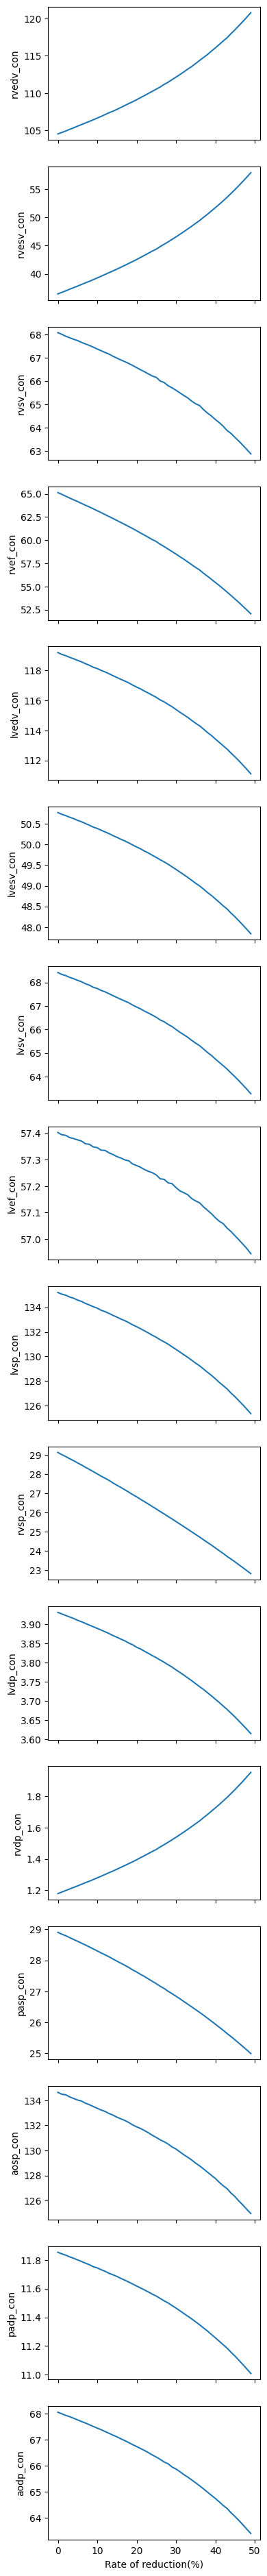

In [5]:
fig, axs = plt.subplots(len(res), 1, figsize=(4, 48), sharex = True)
for i, j in zip(res, range(len(res))):
    axs[j].plot(rate, globals()[f"{i}"])
    axs[j].set_ylabel(f"{i}")
plt.xlabel('Rate of reduction(%)')
plt.show()

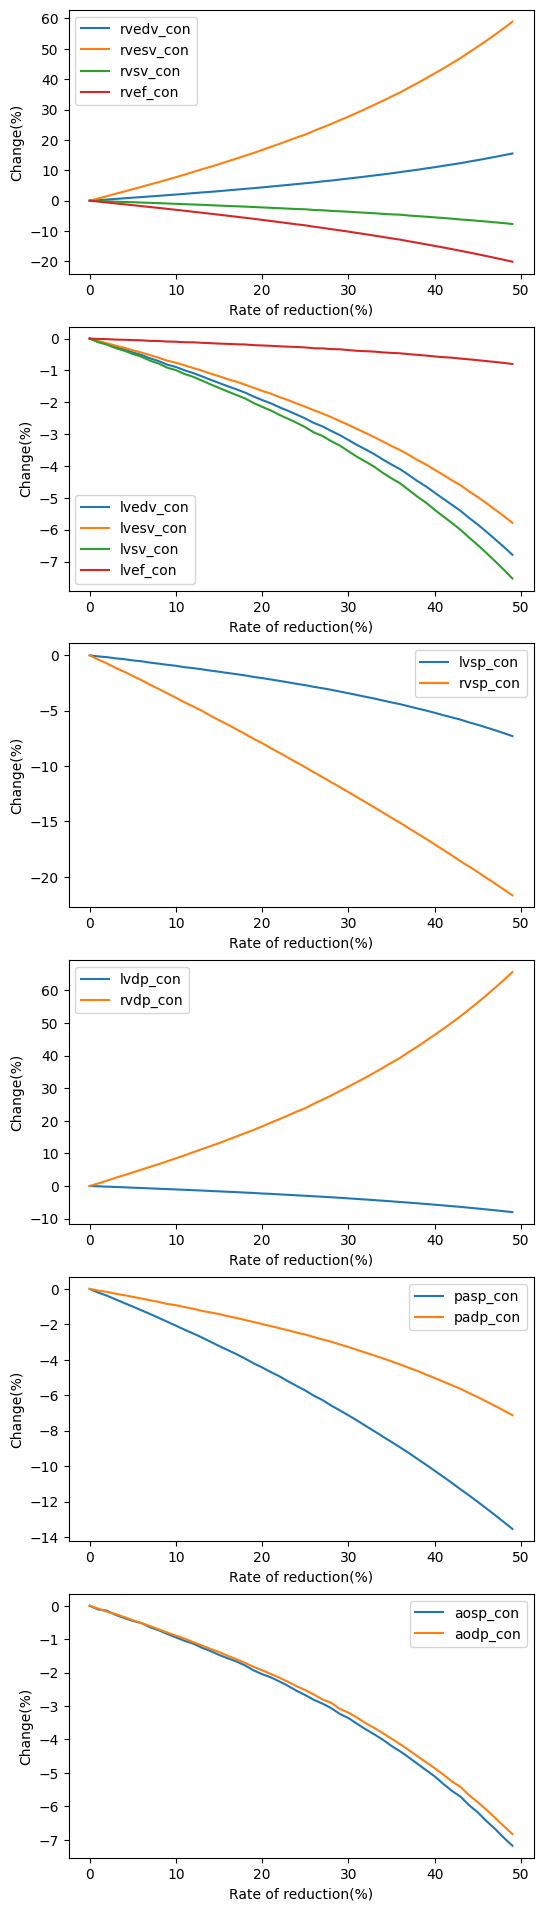

In [6]:
fig, axs = plt.subplots(6, 1, figsize=(6, 24), sharex = False)
res1 = ['rvedv_con', 'rvesv_con', 'rvsv_con', 'rvef_con']
res2 = ['lvedv_con', 'lvesv_con', 'lvsv_con', 'lvef_con']
res3 = ['lvsp_con', 'rvsp_con']
res4 = ['lvdp_con', 'rvdp_con']
res5 = ['pasp_con', 'padp_con']
res6 = ['aosp_con', 'aodp_con']
max_contractility_red = 50
for num in range(1,7):
    for i, j in zip(globals()[f"res{num}"], range(len(globals()[f"res{num}"]))):
        axs[num-1].plot(rate[:max_contractility_red], globals()[f"fun_{i}"][:max_contractility_red],'-', label = f"{i}")
        axs[num-1].set_ylabel('Change(%)')
        #axs[num-1].set_xlim([0,20])
        axs[num-1].set_xlabel('Rate of reduction(%)')
        axs[num-1].legend()
plt.show()

In [7]:
def ODE(params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb
    sol = sp.integrate.solve_ivp(dydt , t, y0 = y_initial , t_eval = t_span, method='LSODA', args = [params])
    sol.t = sol.t[index_range]
    v_lv = sol.y[0][index_range]
    v_la = sol.y[1][index_range]
    q_av = sol.y[2][index_range]
    q_mv = sol.y[3][index_range]
    xi_av = sol.y[4][index_range]
    xi_mv = sol.y[5][index_range]
    pa = sol.y[6][index_range]
    v_rv = sol.y[7][index_range]
    v_ra = sol.y[8][index_range]
    q_tv = sol.y[9][index_range]
    q_pv = sol.y[10][index_range]
    xi_tv = sol.y[11][index_range]
    xi_pv = sol.y[12][index_range]
    pb = sol.y[13][index_range]
    
    p_lv, p_rv, p_la, p_ra, p_ao, p_pa = [], [], [], [], [], []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i))
        p_la.append(la.p(v_la[j], i))
        p_ra.append(ra.p(v_ra[j], i))
        p_rv.append(rv.p(v_rv[j], i))
        p_ao.append(cap_s.pi(q_av[j], pa[j]))
        p_pa.append(cap_p.pi(q_pv[j], pb[j]))
    p_lv, p_rv, p_ao, p_pa, p_la, p_ra= np.array(p_lv)/1333, np.array(p_rv)/1333, np.array(p_ao)/1333, np.array(p_pa)/1333, np.array(p_la)/1333, np.array(p_ra)/1333
    return p_lv, p_rv, p_ao, p_pa, p_la, p_ra, v_lv, v_la, v_rv, v_ra, q_av, q_mv, q_tv, q_pv, xi_av, xi_mv, xi_tv, xi_pv

In [8]:
def dydt(t,y, params):
    C_p, Za_p, R_p = params
    cap_p = PressureSystem(C_p, Za_p, R_p)
    
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

In [9]:
def data_processing(v_lv, v_rv, p_lv, p_rv, p_ao,p_pa):
    max_volume_rv = max(v_rv)
    min_volume_rv = min(v_rv)
    sv_rv = max_volume_rv - min_volume_rv
    rvef = 100*sv_rv / max_volume_rv
    max_volume_lv = max(v_lv)
    min_volume_lv = min(v_lv)
    sv_lv = max_volume_lv - min_volume_lv
    lvef = 100*sv_lv / max_volume_lv
    maxppa = max(p_pa)
    minppa = min(p_pa)
    maxpao = max(p_ao)
    minpao = min(p_ao)
    return sv_rv, sv_lv, rvef, lvef, max_volume_lv, min_volume_lv,  max_volume_rv, min_volume_rv, maxppa, minppa, maxpao, minpao

In [10]:
T = 0.8
lv = heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 3, Emin = 0.08, V0 = 10,T = T, deltat = t_step)# V0 (mL), T (s)
la = heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.17, Emin = 0.08,V0 = 3,T = T, deltat = t_step, delay = 0.85*T) # V0 (mL), T (s)
rv = heart(tau1 = 0.269*T, tau2 = 0.452*T, m1 = 1.32, m2 = 27.4, Emax = 0.8, Emin = 0.04, V0 = 10, T = T, deltat = t_step) # Ks, V0 ,T
ra = heart(tau1 = 0.110*T, tau2 = 0.180*T, m1 = 1.32, m2 = 13.1, Emax = 0.15, Emin = 0.04, V0 = 3, T = T, deltat = t_step, delay = 0.85*T) # Ks, V0, T
av = ValveinP(density = 1.06, eff_length = 2.2,Aann = 5, Kvo = 0.12,Kvc = 0.15, p_oc = 0)
mv = ValveinP(density = 1.06,eff_length =1.9,Aann = 5, Kvo = 0.3,Kvc = 0.4, p_oc = 0)
tv = ValveinP(1.06,2,6, 0.3,0.4, 0) #poc (mmHg)
pv = ValveinP(1.06,1.9,2.8, 0.2,0.2, 0) #poc
data = np.array([
 0.00061      , 103.44867    , 1471.26289 , 0.00272, 26.6, 165
])
C_s, Za_s, R_s, C_p, Za_p, R_p = data[0], data[1], data[2], data[3], data[4], data[5]
cap_s=PressureSystem(C_s, Za_s, R_s)
cap_p=PressureSystem(C_p, Za_p, R_p)
input_para = [[0.00272, 26.6, 165]]
labels = [' Healthy']
rm = [0]
for n in np.arange(5,50,5):
    pul_cir = lumped_resection_unified(C = cap_p.C, Za = cap_p.Za, R = cap_p.R, n = n, N =100)
    R = pul_cir.updated_R()
    Za = pul_cir.updated_Za()
    C = pul_cir.updated_C()
    input_para.append([C, Za, R])
    labels.append('Lung removed {}% '.format(n))
    rm.append(n)
input_para = np.array(input_para)
results = np.array(p_map(ODE, input_para, num_cpus = 32))
p_lv_res = results[:, 0]
p_rv_res = results[:, 1]
p_pa_res = results[:, 3]
v_rv_res = results[:, 8]
v_lv_res = results[:, 6]
p_ao_res = results[:, 2]
p_pa_res = results[:, 3]
results_res = np.array(p_map(data_processing, v_lv_res, v_rv_res, p_lv_res, p_rv_res, p_ao_res, p_pa_res, num_cpus = 32))
rvsv_aft, lvsv_aft, rvef_aft, lvef_aft, lvedv_aft, lvesv_aft, rvedv_aft, rvesv_aft, maxppa_aft, minppa_aft, maxpao_aft, minpao_aft = results_res[:, 0], results_res[:, 1], results_res[:, 2], results_res[:, 3], results_res[:,4], results_res[:,5], results[:,6], results[:,7], results[:,8], results[:,9], results[:,10], results[:,11]
rvedv_aft = []
rvesv_aft = []
lvedv_aft = []
lvesv_aft = []
pasp_aft = []
padp_aft = []
rvsp_aft = []
lvsp_aft = []
rvdp_aft = []
lvdp_aft = []
for i in range(len(v_rv_res)):
    lvsp_aft.append(max(p_lv_res[i]))
    rvedv_aft.append(max(v_rv_res[i]))
    rvesv_aft.append(min(v_rv_res[i]))
    lvedv_aft.append(max(v_lv_res[i]))
    lvesv_aft.append(min(v_lv_res[i]))
    pasp_aft.append(max(p_pa_res[i]))
    padp_aft.append(min(p_pa_res[i]))
    rvsp_aft.append(max(p_rv_res[i]))
    rvdp_aft.append(min(p_rv_res[i]))
    lvdp_aft.append(min(p_lv_res[i]))
rvedv_aft = np.array(rvedv_aft)
rvesv_aft = np.array(rvesv_aft)
lvedv_aft = np.array(lvedv_aft)
lvesv_aft = np.array(lvesv_aft)
pasp_aft = np.array(pasp_aft)
padp_aft = np.array(padp_aft)
rvsp_aft = np.array(rvsp_aft)
lvsp_aft = np.array(lvsp_aft)
lvdp_aft = np.array(lvdp_aft)
rvdp_aft = np.array(rvdp_aft)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

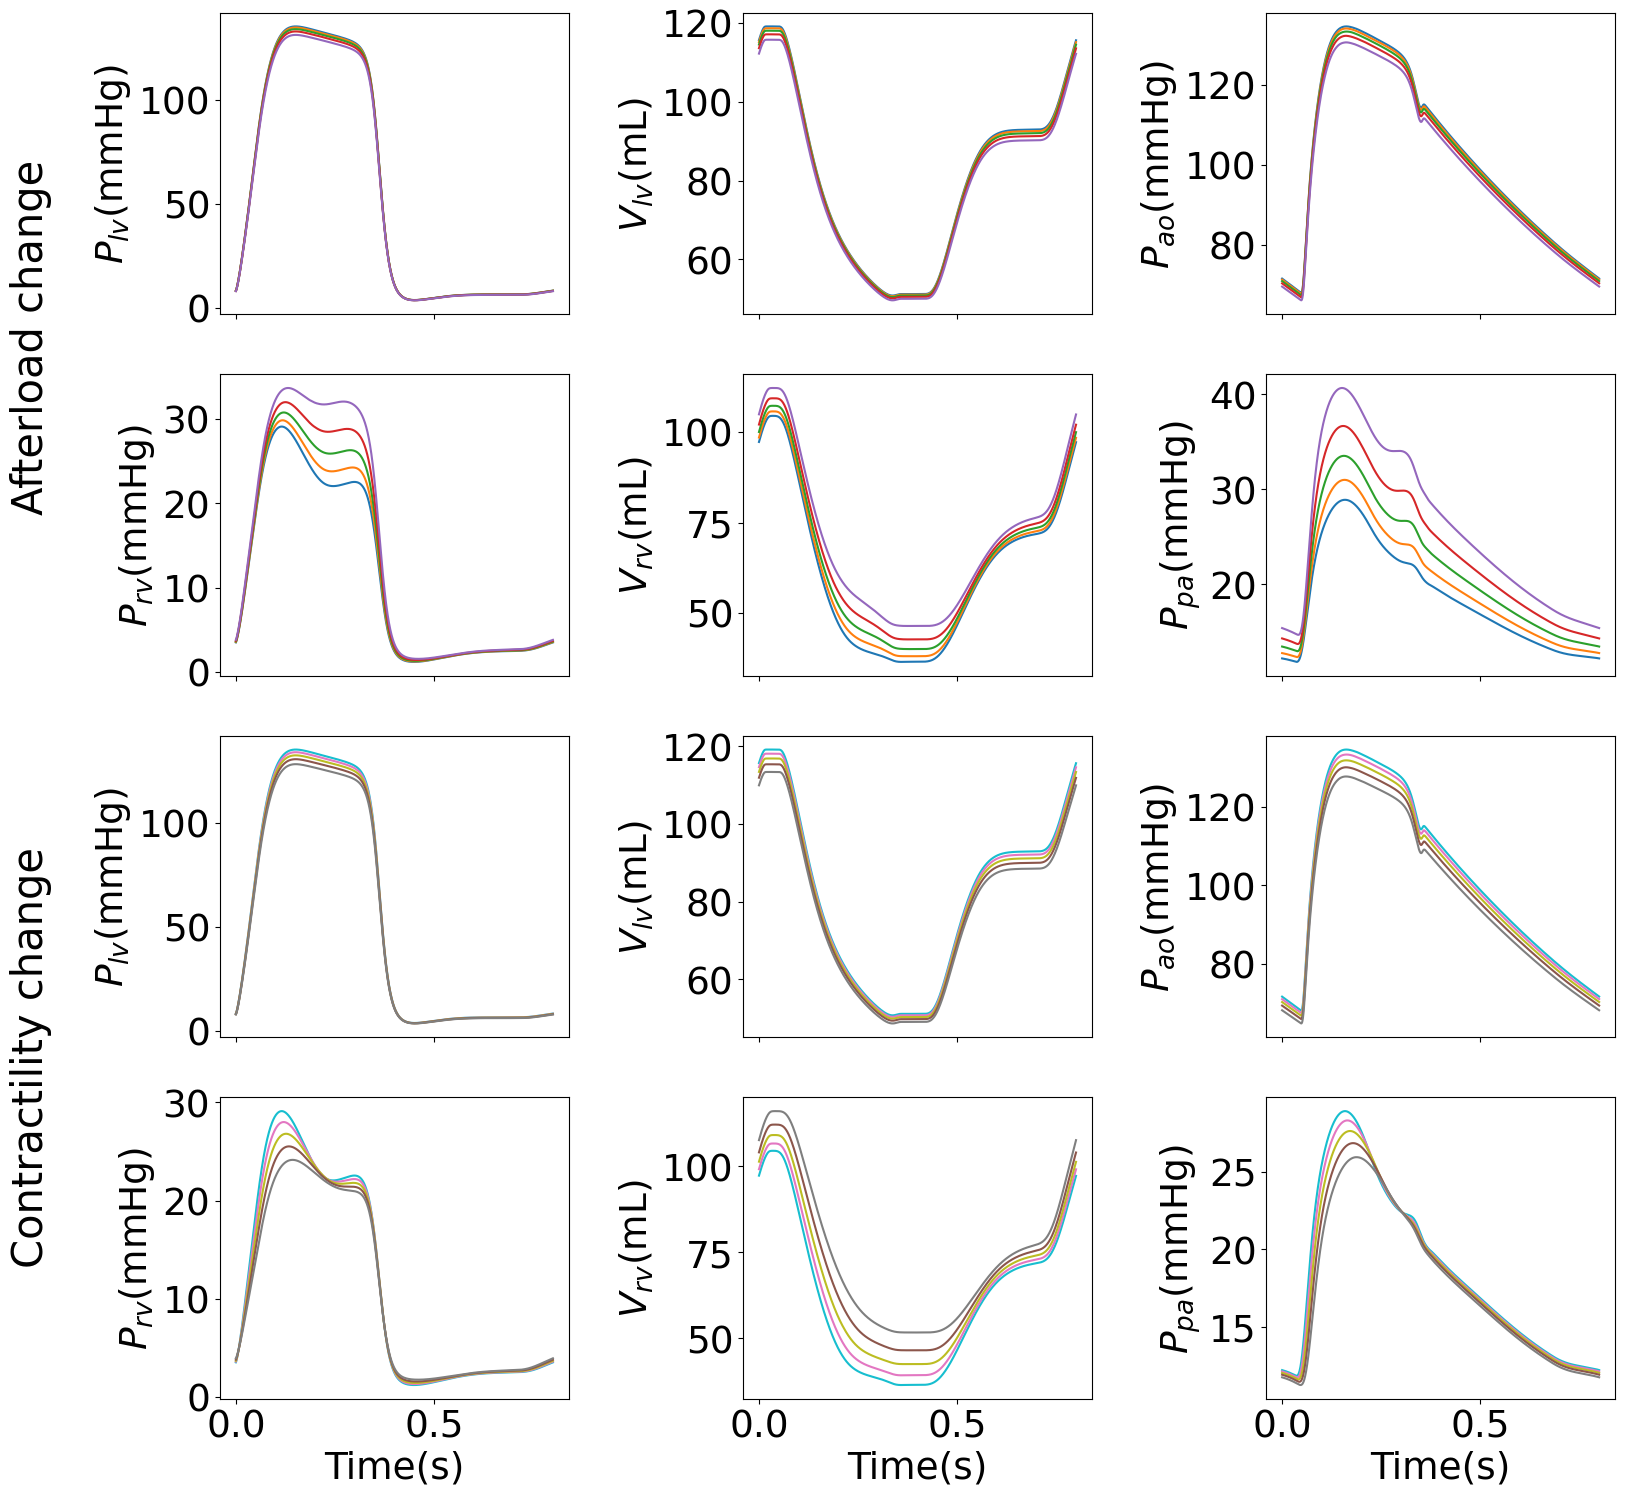

In [11]:
fig, axs = plt.subplots(4, 3, figsize=(18, 18),sharex = True)
time = np.arange(0,T,t_step)
label1 = ['p_lv_res', 'v_lv_res', 'p_ao_res']
label2 = ['p_rv_res', 'v_rv_res', 'p_pa_res']
label3 = ['p_lv_con', 'v_lv_con', 'p_ao_con']
label4 = ['p_rv_con', 'v_rv_con', 'p_pa_con']
color1 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color2 = ['#17becf', '#e377c2', '#bcbd22', '#8c564b', '#7f7f7f']
for i in range(0,4):
    if i == 0:
        label = label1
    elif i ==1:
        label = label2
    elif i ==2:
        label = label3
    else:
        label = label4
    for j in range(0,3):
        if i<=1:
            count = 0
            for k in range(0,len(rm),2):
                axs[i,j].plot(time, globals()[f'{label[j]}'][k], label = f'Lung removed {rm[k]}%', color = color1[count])
                count = count + 1
        else:
            count = 0
            for k in range(0,len(rate),10):
                axs[i,j].plot(time, globals()[f'{label[j]}'][k], label = f'{rate[k]}% reduction', color = color2[count])
                count = count + 1
fontsize = 30
axs[3, 0].set_xlabel('Time(s)', fontsize = fontsize)
axs[3, 1].set_xlabel('Time(s)', fontsize = fontsize)
axs[3, 2].set_xlabel('Time(s)', fontsize = fontsize)
axs[0, 0].set_ylabel(r'$P_{lv}$(mmHg)', fontsize = fontsize)
axs[1, 0].set_ylabel(r'$P_{rv}$(mmHg)', fontsize = fontsize)
axs[2, 0].set_ylabel(r'$P_{lv}$(mmHg)', fontsize = fontsize)
axs[3, 0].set_ylabel(r'$P_{rv}$(mmHg)', fontsize = fontsize)
axs[0, 1].set_ylabel(r'$V_{lv}$(mL)', fontsize = fontsize)
axs[1, 1].set_ylabel(r'$V_{rv}$(mL)', fontsize = fontsize)
axs[2, 1].set_ylabel(r'$V_{lv}$(mL)', fontsize = fontsize)
axs[3, 1].set_ylabel(r'$V_{rv}$(mL)', fontsize = fontsize)
axs[0, 2].set_ylabel(r'$P_{ao}$(mmHg)', fontsize = fontsize)
axs[1, 2].set_ylabel(r'$P_{pa}$(mmHg)', fontsize = fontsize)
axs[2, 2].set_ylabel(r'$P_{ao}$(mmHg)', fontsize = fontsize)
axs[3, 2].set_ylabel(r'$P_{pa}$(mmHg)', fontsize = fontsize)
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize-3)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize-3)
    ax.tick_params(axis = 'x', labelsize = fontsize-3)
    ax.tick_params(axis = 'y', labelsize = fontsize-3)
fig.text(0.02, 0.7, 'Afterload change', ha='center', fontsize=30,va='center', rotation=90)
fig.text(0.02, 0.3, 'Contractility change', ha='center', fontsize=30,va='center', rotation=90)
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.savefig('volume_pressure.svg', format='svg', bbox_inches='tight')
plt.show()

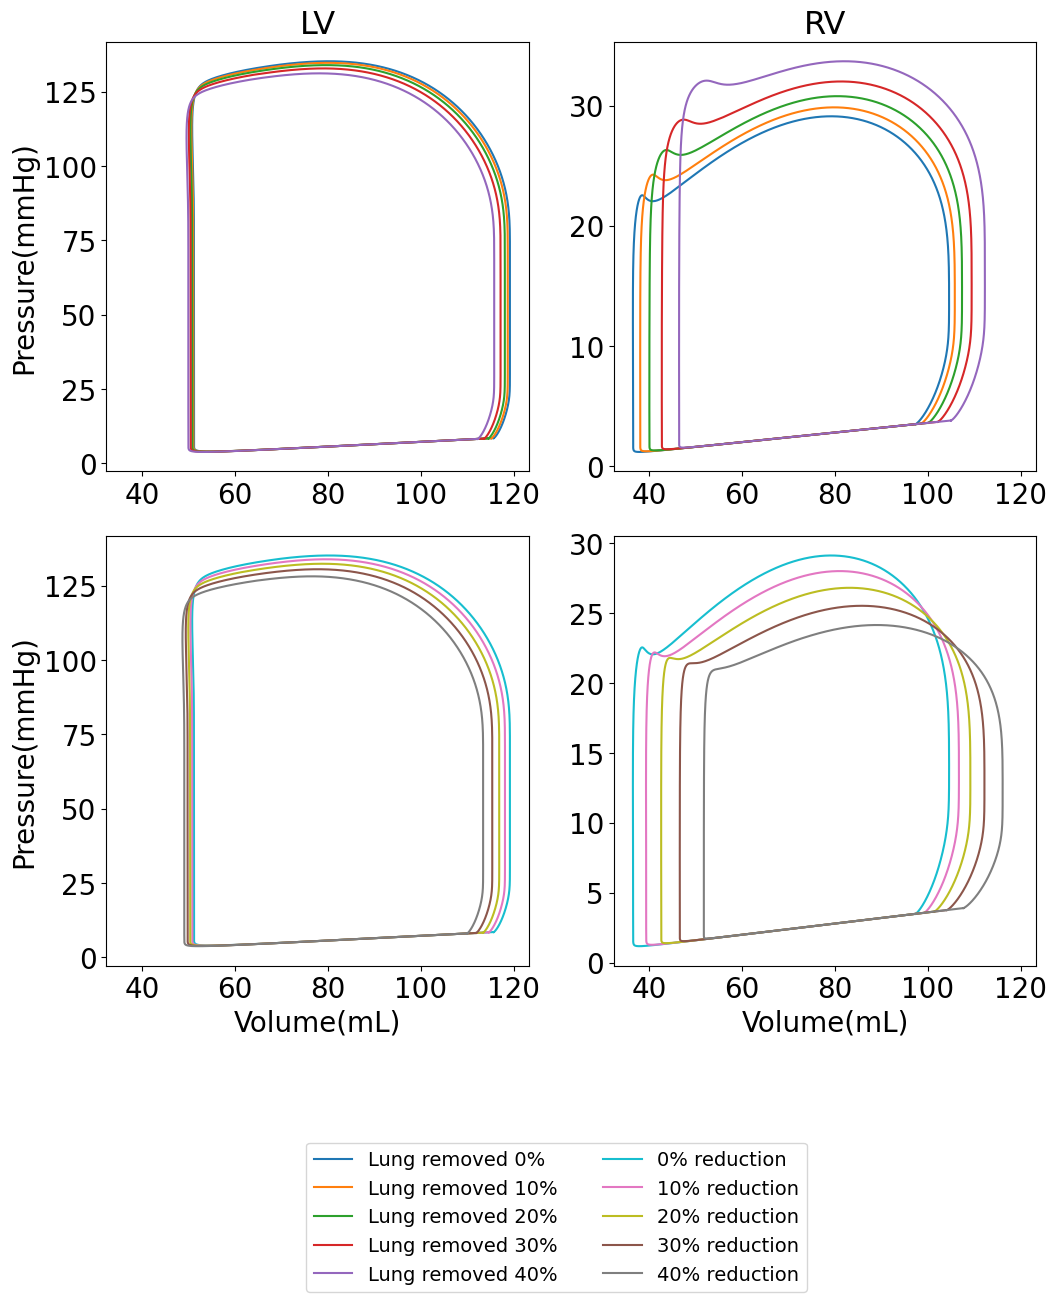

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1]}, sharex='row')
fontsize = 23
count = 0
for i, j in zip(range(0,len(rm),2), rm):
    axs[0,0].plot(v_lv_res[i], p_lv_res[i], label = f'Lung removed {rm[i]}% ', color = color1[count])
    axs[0,1].plot(v_rv_res[i], p_rv_res[i], color = color1[count])
    count = count + 1
axs[0,0].set_ylabel('Pressure(mmHg)',fontsize=fontsize)
count = 0
for i in range(0,len(rate),10):
    axs[1,1].plot(v_rv_con[i], p_rv_con[i], label = f'{rate[i]}% reduction', color = color2[count])
    axs[1,0].plot(v_lv_con[i], p_lv_con[i], color = color2[count])
    count = count + 1
axs[1,1].set_xlabel('Volume(mL)', fontsize=fontsize)
axs[1,0].set_ylabel('Pressure(mmHg)', fontsize=fontsize)
axs[1,0].set_xlabel('Volume(mL)', fontsize=fontsize)
axs[0,0].set_title('LV',fontsize = fontsize)
axs[0,1].set_title('RV',fontsize = fontsize)
for ax in axs.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize-3)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize-3)
    ax.tick_params(axis = 'x', labelsize = fontsize-3)
    ax.tick_params(axis = 'y', labelsize = fontsize-3)
plt.subplots_adjust(wspace=0.2, hspace=0.15)  # 调整水平和垂直间距

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.17), fontsize=14)
plt.title
plt.savefig('PV_loop_compare.svg', format='svg', bbox_inches='tight')
plt.savefig('PV_loop_compare.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [67]:
def err_cal(params):
    err = []
    for i in range(len(params)):
        diff = (params[i] - params[0])/params[0]
        err.append(diff*100)
    err = np.array(err)
    return err
err_rvsp = err_cal(rvsp_aft)
err_pasp = err_cal(pasp_aft)
err_padp = err_cal(padp_aft)
err_rvedv = err_cal(rvedv_aft)
err_rvesv = err_cal(rvesv_aft)
err_lvedv = err_cal(lvedv_aft)
err_lvesv = err_cal(lvesv_aft)
err_lvef = err_cal(lvef_aft)
err_rvef = err_cal(rvef_aft)
err_lvsv = err_cal(lvsv_aft)
err_rvsv = err_cal(rvsv_aft)

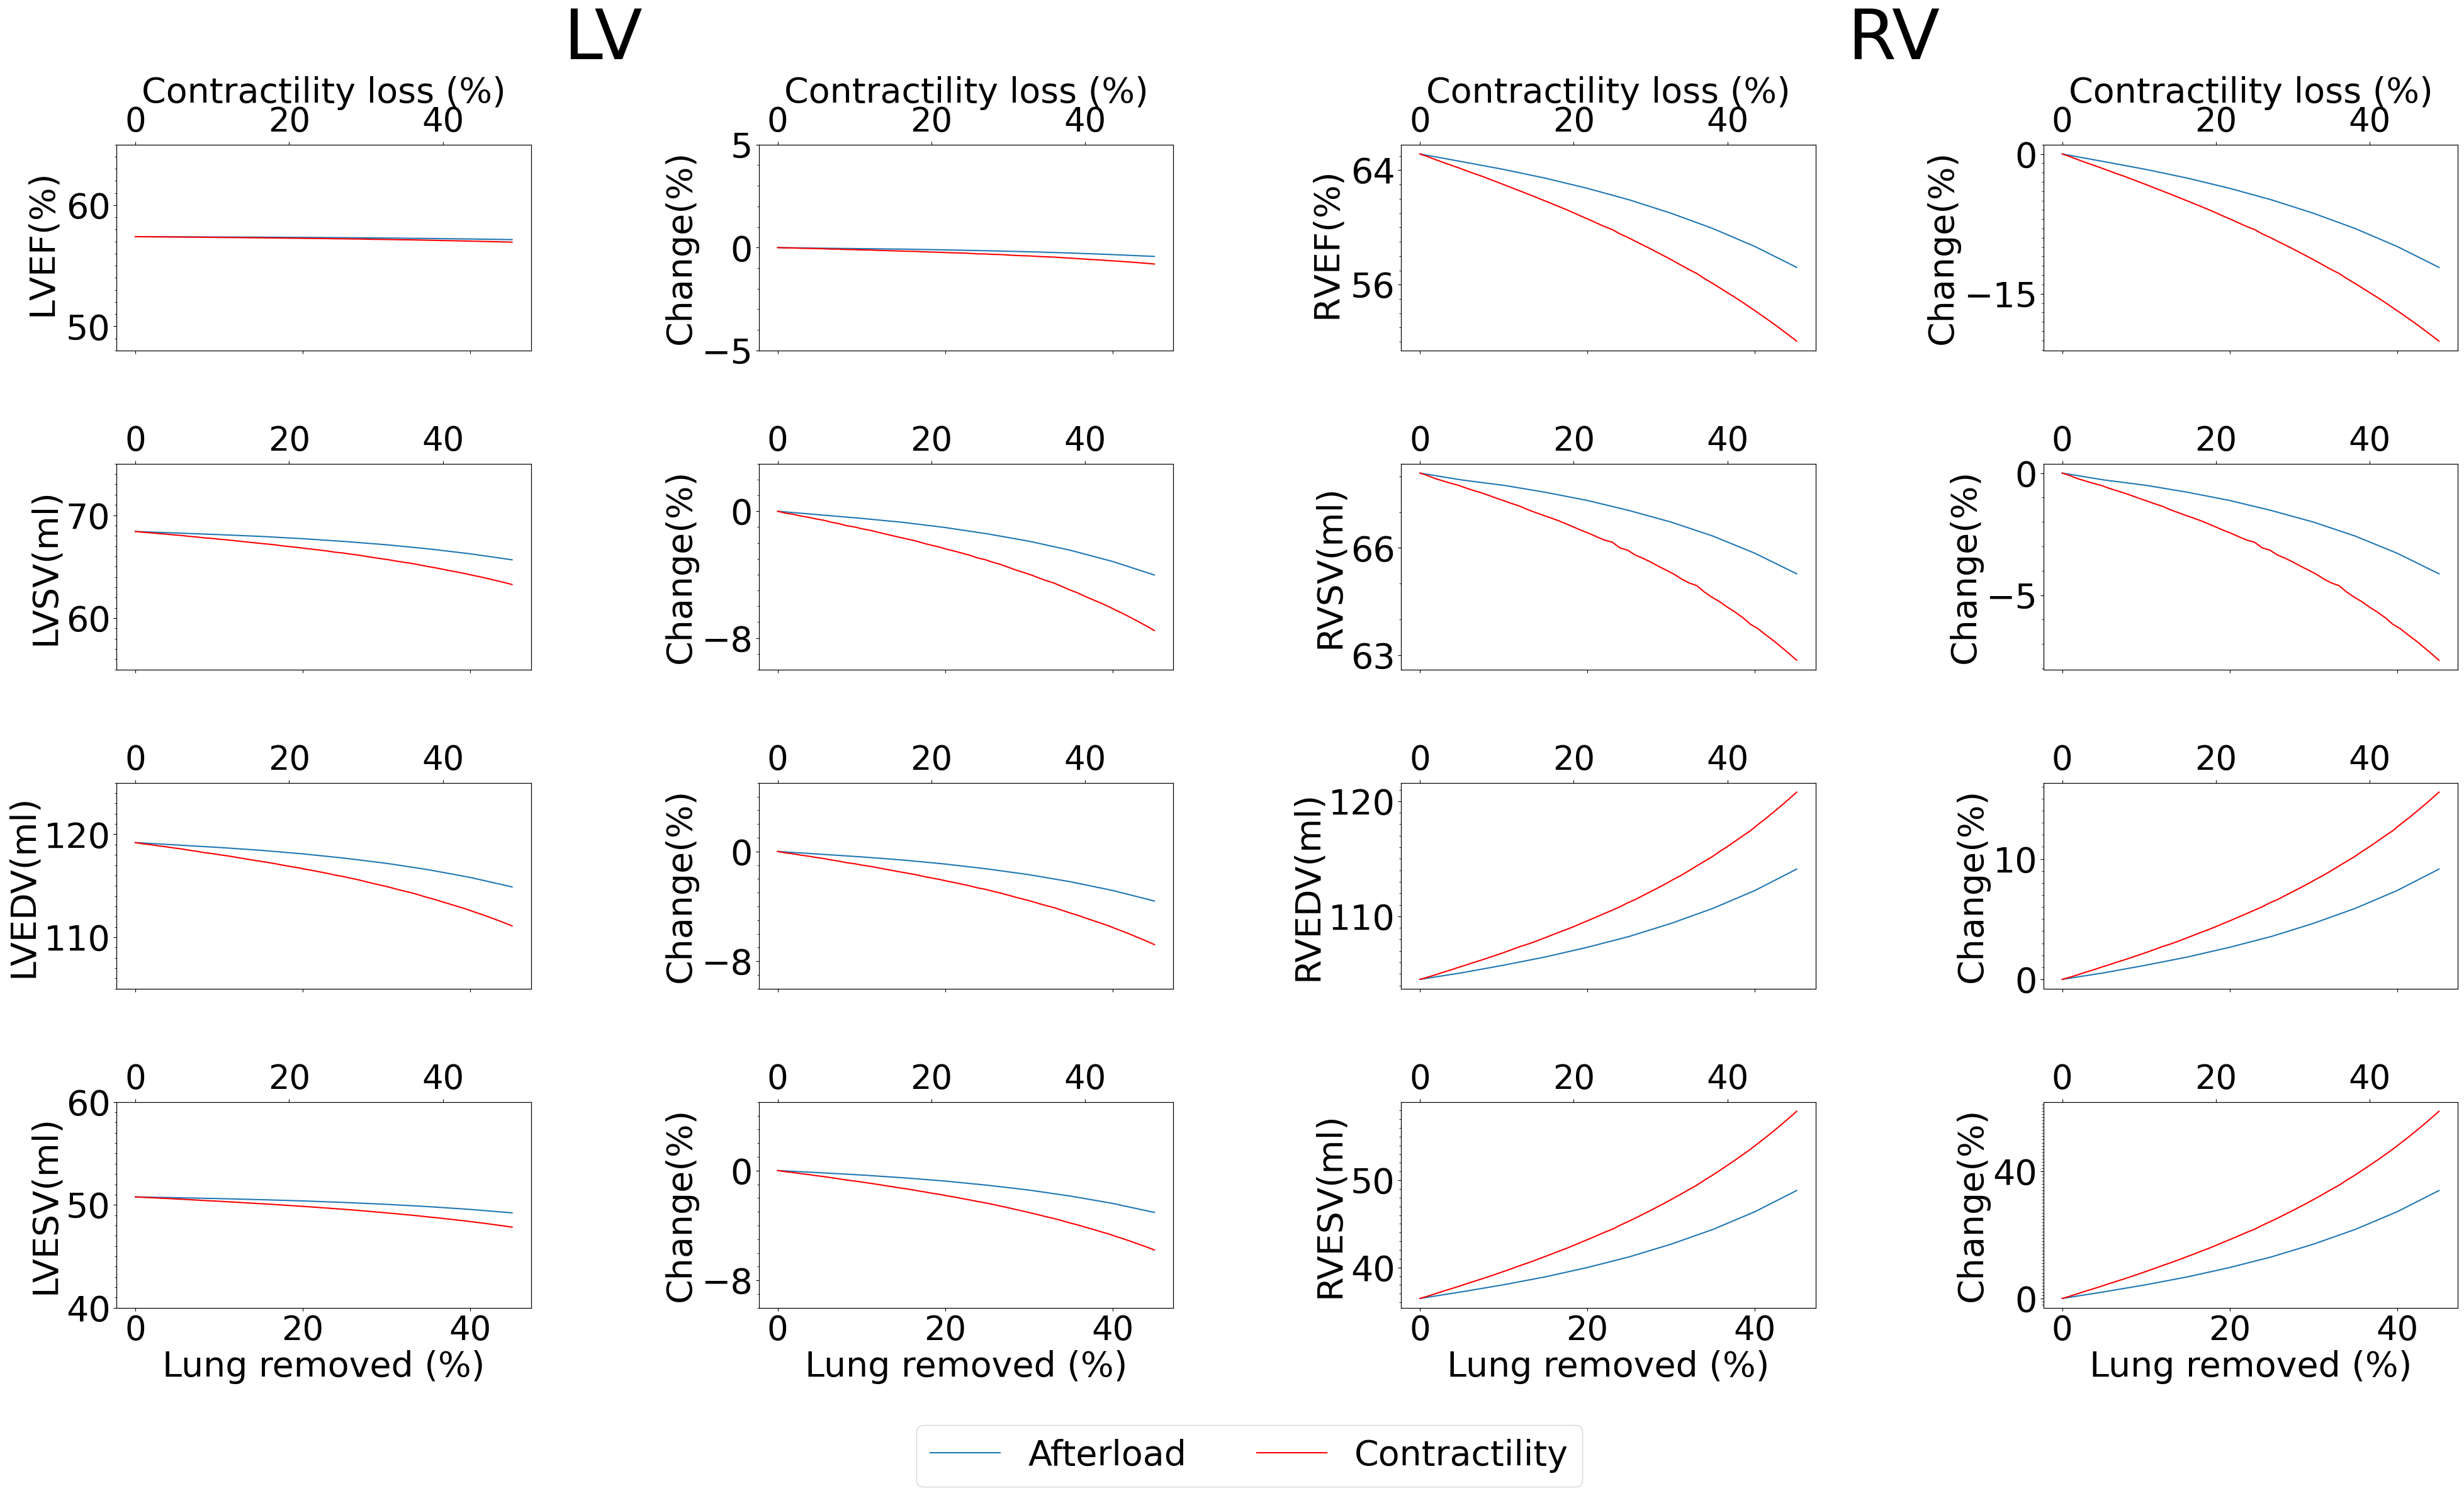

In [165]:
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
xaxis = range(0,18)
labels = [str(i) for i in range(len(xaxis))]
fontsize = 40
fig, axs = plt.subplots(4, 4, figsize=(48, 24),sharex= True) 
label = ['ef', 'sv', 'edv', 'esv']
Label = ['EF', 'SV', 'EDV', 'ESV']
unit = ['$(\%)$', '(ml)','(ml)','(ml)']
for j in range(0,4,2):
    for i, lab, uni, Lab in zip(range(4), label, unit, Label):
        if j<2:
            lab = 'lv'+lab
            Lab = 'LV'+Lab
        else:
            lab = 'rv' + lab
            Lab = 'RV'+Lab
        axs[i,j].plot(rm, globals()[f'{lab}_aft'],linestyle='-', label = 'Afterload')
        globals()['ax{i}{j}'] = axs[i,j].twiny()
        globals()['ax{i}{j}'].plot(rate, globals()[f'{lab}_con'], linestyle='-',color = 'red', label = 'Contractility')
        globals()['ax{i}{j}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        axs[i,j].set_ylabel(fr'{Lab}{uni}', fontsize = fontsize)
        axs[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
        globals()[f'err_{lab}'] = err_cal(globals()[f'{lab}_aft'])
        globals()['ax{i}{j+1}'] = axs[i,j+1].twiny() 
        axs[i,j+1].plot(rm, globals()[f'err_{lab}'], linestyle = '-')#functional change of afterload
        globals()['ax{i}{j+1}'].plot(rate, globals()[f'fun_{lab}_con'], linestyle = '-',color = 'red')# functional change of contractility
        axs[i,j+1].set_ylabel(f'Change(%)', fontsize = fontsize)
        globals()['ax{i}{j+1}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j+1}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        if i == 0:
            globals()['ax{i}{j}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
            globals()['ax{i}{j+1}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
        
            
axs[0,0].set_ylim(48,65)
axs[0,1].set_ylim(-5,5)
axs[1,0].set_ylim(55,75)
axs[1,1].set_ylim(-10,3)
axs[2,0].set_ylim(105,125)
axs[2,1].set_ylim(-10,5)
axs[3,0].set_ylim(40,60)
axs[3,1].set_ylim(-10,5)
axs[3,0].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[3,1].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[3,2].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[3,3].set_xlabel('Lung removed (%)', fontsize = fontsize)
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
plt.subplots_adjust(wspace = 0.55)
plt.subplots_adjust(hspace = 0.55)
i,j = 0,0
handles_0_0, labels_0_0 = axs[0, 0].get_legend_handles_labels()
handles_1_1, labels_1_1 = globals()['ax{i}{j}'].get_legend_handles_labels()
handles = handles_0_0 + handles_1_1
labels = labels_0_0 + labels_1_1
plt.text(-195, 390, "LV", fontsize=80, color='Black')
plt.text(-28, 390, "RV", fontsize=80, color='Black')
fig.legend(handles, labels,loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=40)

plt.savefig('rate_remove_volume.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
xaxis = range(0,18)
labels = [str(i) for i in range(len(xaxis))]
fontsize = 40
fig, axs = plt.subplots(3, 4, figsize=(48, 24),sharex= True) 
label = ['sp', 'dp']
Label = ['SP', 'DP']
unit = ['$(mmHg)$', '$(mmHg)$']
for i in range(0, 3):
    for j, lab, uni, Lab in zip(range(0, 4, 2), label, unit, Label):
        if i ==0:
            lab = 'lv'+lab
            Lab = 'LV'+Lab
        elif i ==1:
            lab = 'rv' + lab
            Lab = 'RV'+Lab
        elif i ==2:
            lab = 'pa' + lab
            Lab = 'PA'+Lab
        axs[i,j].plot(rm, globals()[f'{lab}_aft'],linestyle='-', label = 'Afterload')
        globals()['ax{i}{j}'] = axs[i,j].twiny()
        globals()['ax{i}{j}'].plot(rate, globals()[f'{lab}_con'], linestyle='-',color = 'red', label = 'Contractility')
        globals()['ax{i}{j}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        axs[i,j].set_ylabel(fr'{Lab}{uni}', fontsize = fontsize)
        axs[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
        globals()[f'err_{lab}'] = err_cal(globals()[f'{lab}_aft'])
        globals()['ax{i}{j+1}'] = axs[i,j+1].twiny()
        axs[i,j+1].plot(rm, globals()[f'err_{lab}'], linestyle = '-')#function change of afterload
        globals()['ax{i}{j+1}'].plot(rate, globals()[f'fun_{lab}_con'], linestyle = '-',color = 'red')# function change of contractility
        axs[i,j+1].set_ylabel(f'Change(%)', fontsize = fontsize)
        globals()['ax{i}{j+1}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j+1}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        if i == 0:
            globals()['ax{i}{j}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
            globals()['ax{i}{j+1}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
plt.subplots_adjust(wspace = 0.55)
plt.subplots_adjust(hspace = 0.55)
i,j = 0,0
handles_0_0, labels_0_0 = axs[0, 0].get_legend_handles_labels()
handles_1_1, labels_1_1 = globals()['ax{i}{j}'].get_legend_handles_labels()
handles = handles_0_0 + handles_1_1
labels = labels_0_0 + labels_1_1
axs[2,0].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,1].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,2].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,3].set_xlabel('Lung removed (%)', fontsize = fontsize)
fig.legend(handles, labels,loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=40)
plt.text(-285, 131, "LV", fontsize=80, color='Black')
plt.text(-285, 72, "RV", fontsize=80, color='Black')
plt.text(-285, 9, "PA", fontsize=80, color='Black')

plt.text(-193, 170, "SP", fontsize=80, color='Black')
plt.text(-27, 170, "DP", fontsize=80, color='Black')
plt.savefig('rate_remove_pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()

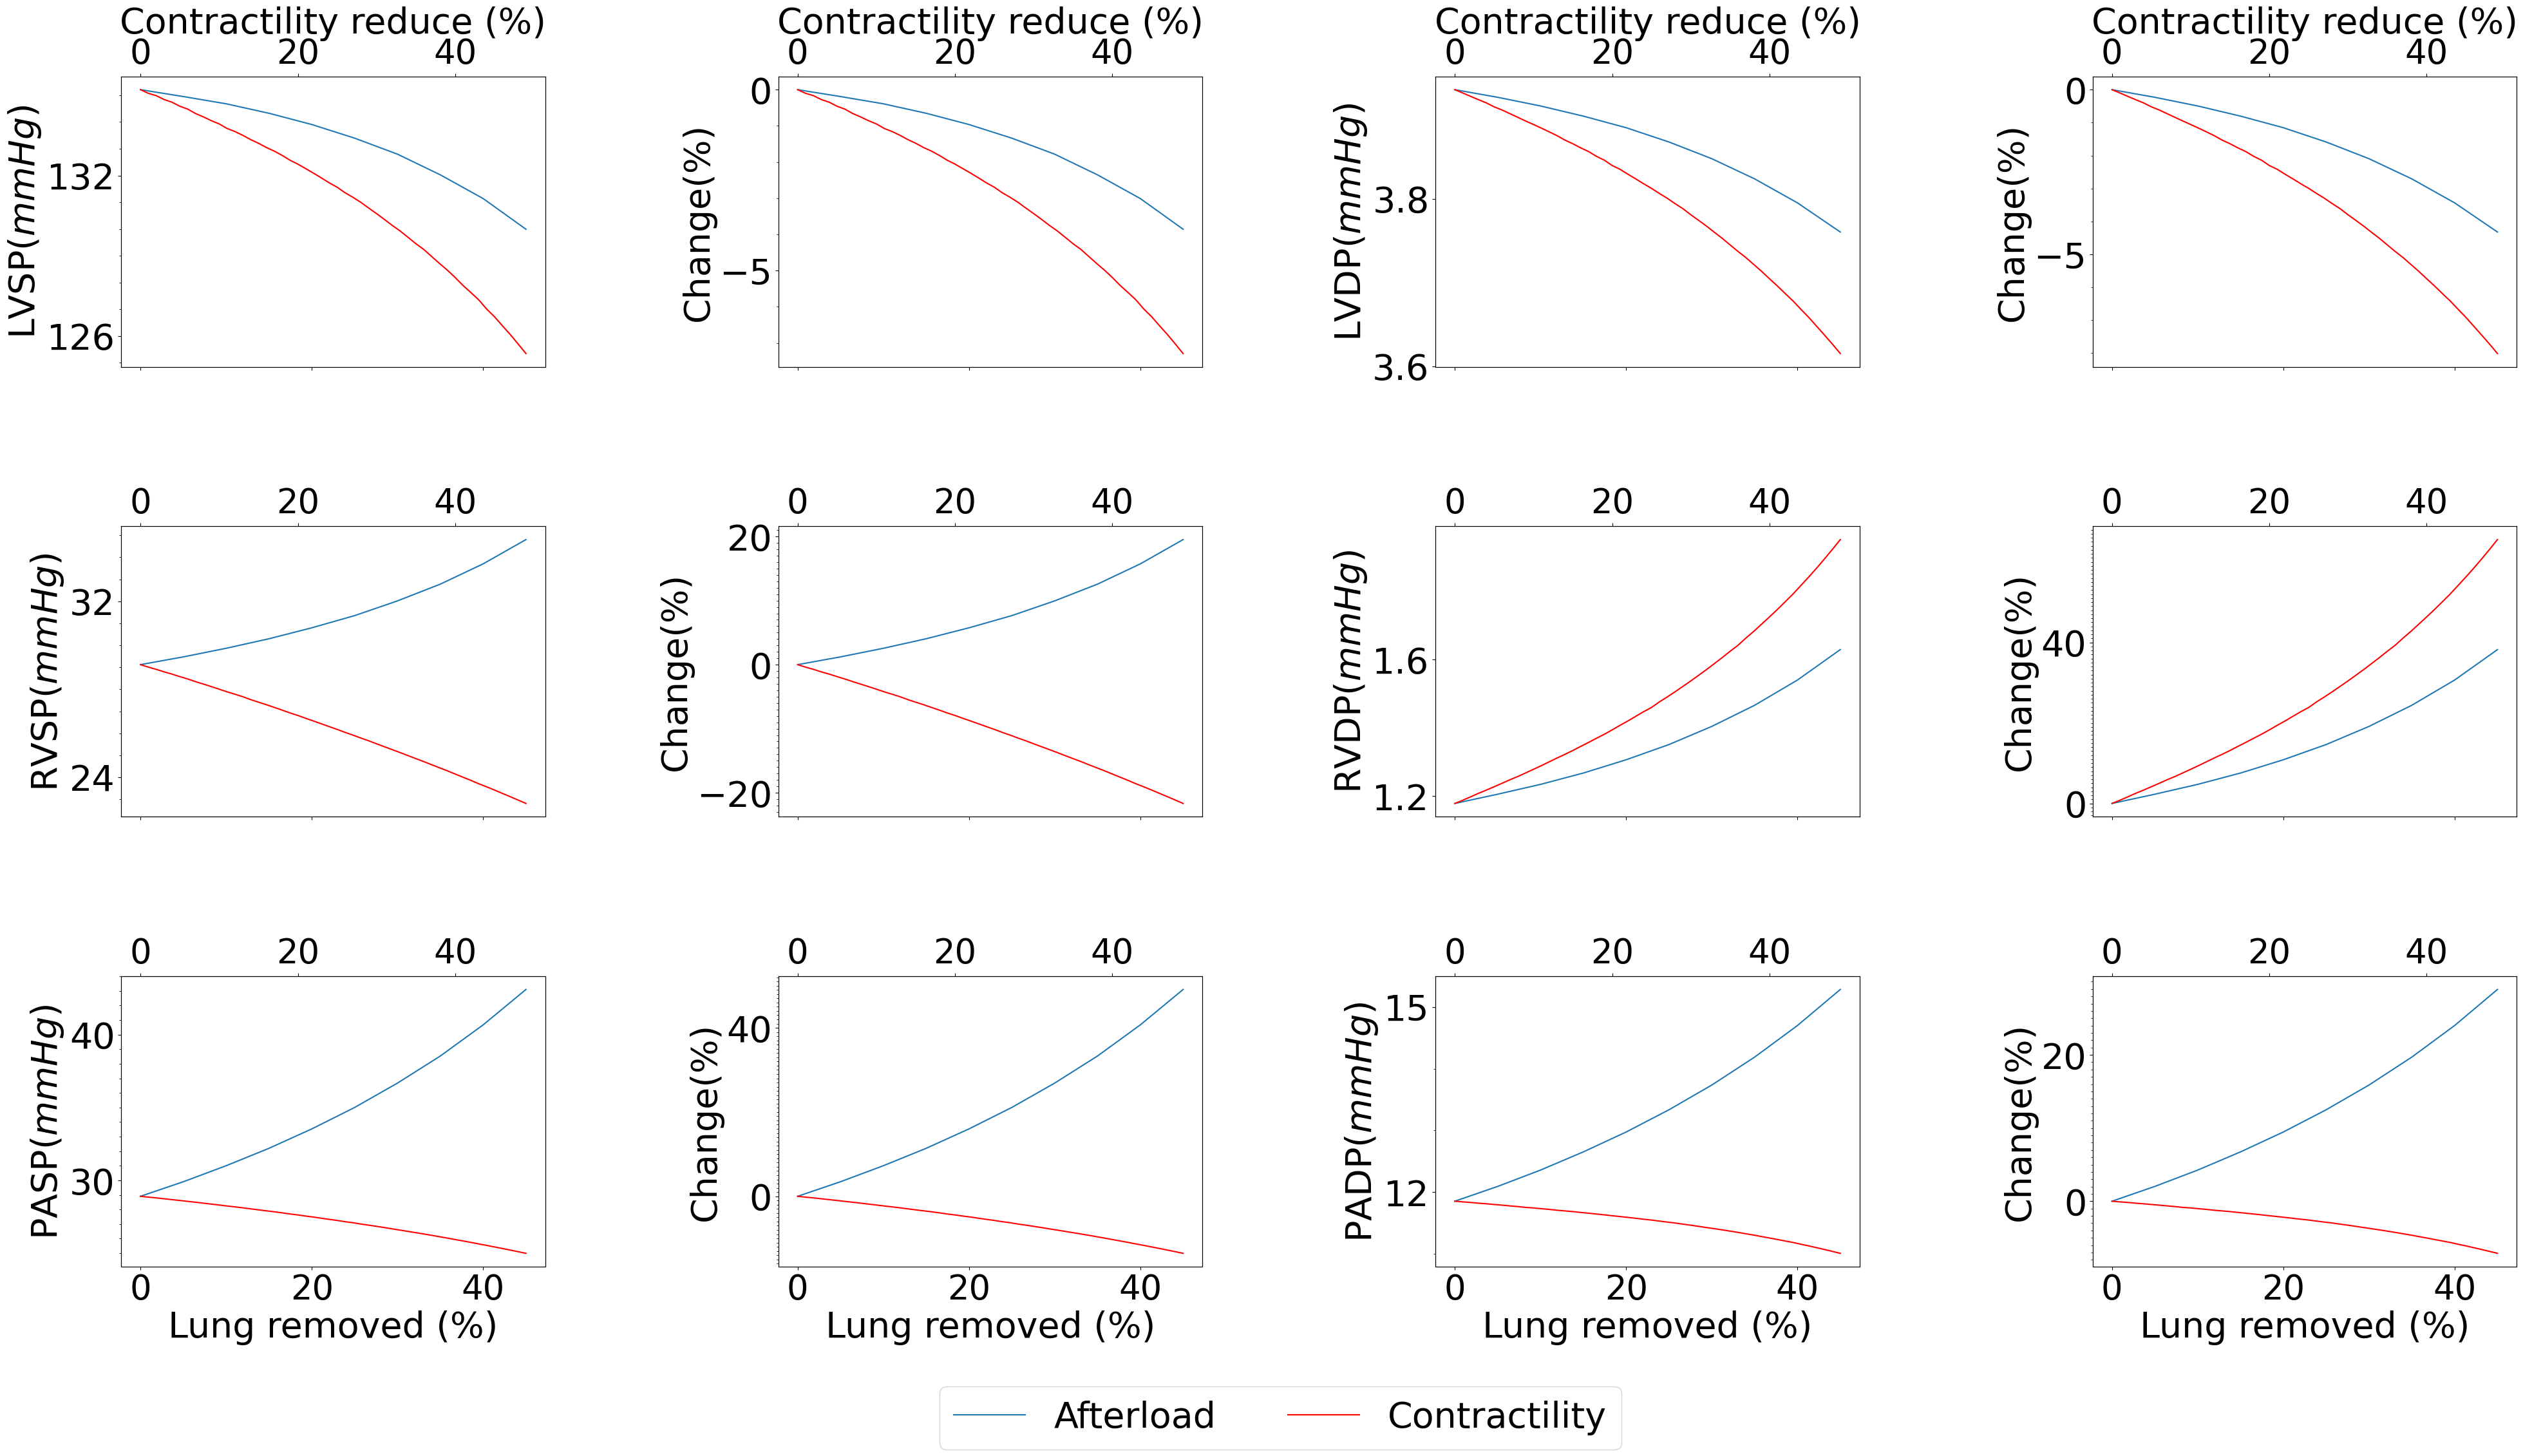

In [111]:
import matplotlib.ticker as ticker
xaxis = range(0,18)
labels = [str(i) for i in range(len(xaxis))]
fontsize = 40
fig, axs = plt.subplots(3, 4, figsize=(48, 24),sharex= True) 
label = ['sp', 'dp']
Label = ['SP', 'DP']
unit = ['$(mmHg)$', '$(mmHg)$']
for i in range(0, 3):
    for j, lab, uni, Lab in zip(range(0, 4, 2), label, unit, Label):
        if i ==0:
            lab = 'lv'+lab
            Lab = 'LV'+Lab
        elif i ==1:
            lab = 'rv' + lab
            Lab = 'RV'+Lab
        elif i ==2:
            lab = 'pa' + lab
            Lab = 'PA'+Lab
        axs[i,j].plot(rm, globals()[f'{lab}_aft'],linestyle='-', label = 'Afterload')
        globals()['ax{i}{j}'] = axs[i,j].twiny()
        globals()['ax{i}{j}'].plot(rate, globals()[f'{lab}_con'], linestyle='-',color = 'red', label = 'Contractility')
        globals()['ax{i}{j}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        axs[i,j].set_ylabel(fr'{Lab}{uni}', fontsize = fontsize)
        axs[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
        globals()[f'err_{lab}'] = err_cal(globals()[f'{lab}_aft'])
        globals()['ax{i}{j+1}'] = axs[i,j+1].twiny()
        axs[i,j+1].plot(rm, globals()[f'err_{lab}'], linestyle = '-')#function change of afterload
        globals()['ax{i}{j+1}'].plot(rate, globals()[f'fun_{lab}_con'], linestyle = '-',color = 'red')# function change of contractility
        axs[i,j+1].set_ylabel(f'Change(%)', fontsize = fontsize)
        globals()['ax{i}{j+1}'].tick_params(axis = 'x', labelsize = fontsize - 2)
        globals()['ax{i}{j+1}'].xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
        if i == 0:
            globals()['ax{i}{j}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
            globals()['ax{i}{j+1}'].set_xlabel('Contractility loss (%)', fontsize = fontsize)
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
plt.subplots_adjust(wspace = 0.55)
plt.subplots_adjust(hspace = 0.55)
i,j = 0,0
handles_0_0, labels_0_0 = axs[0, 0].get_legend_handles_labels()
handles_1_1, labels_1_1 = globals()['ax{i}{j}'].get_legend_handles_labels()
handles = handles_0_0 + handles_1_1
labels = labels_0_0 + labels_1_1
axs[2,0].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,1].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,2].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2,3].set_xlabel('Lung removed (%)', fontsize = fontsize)
fig.legend(handles, labels,loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=5, fontsize=40)

plt.savefig('rate_remove_pressure.pdf', format='pdf', bbox_inches='tight')
plt.show()

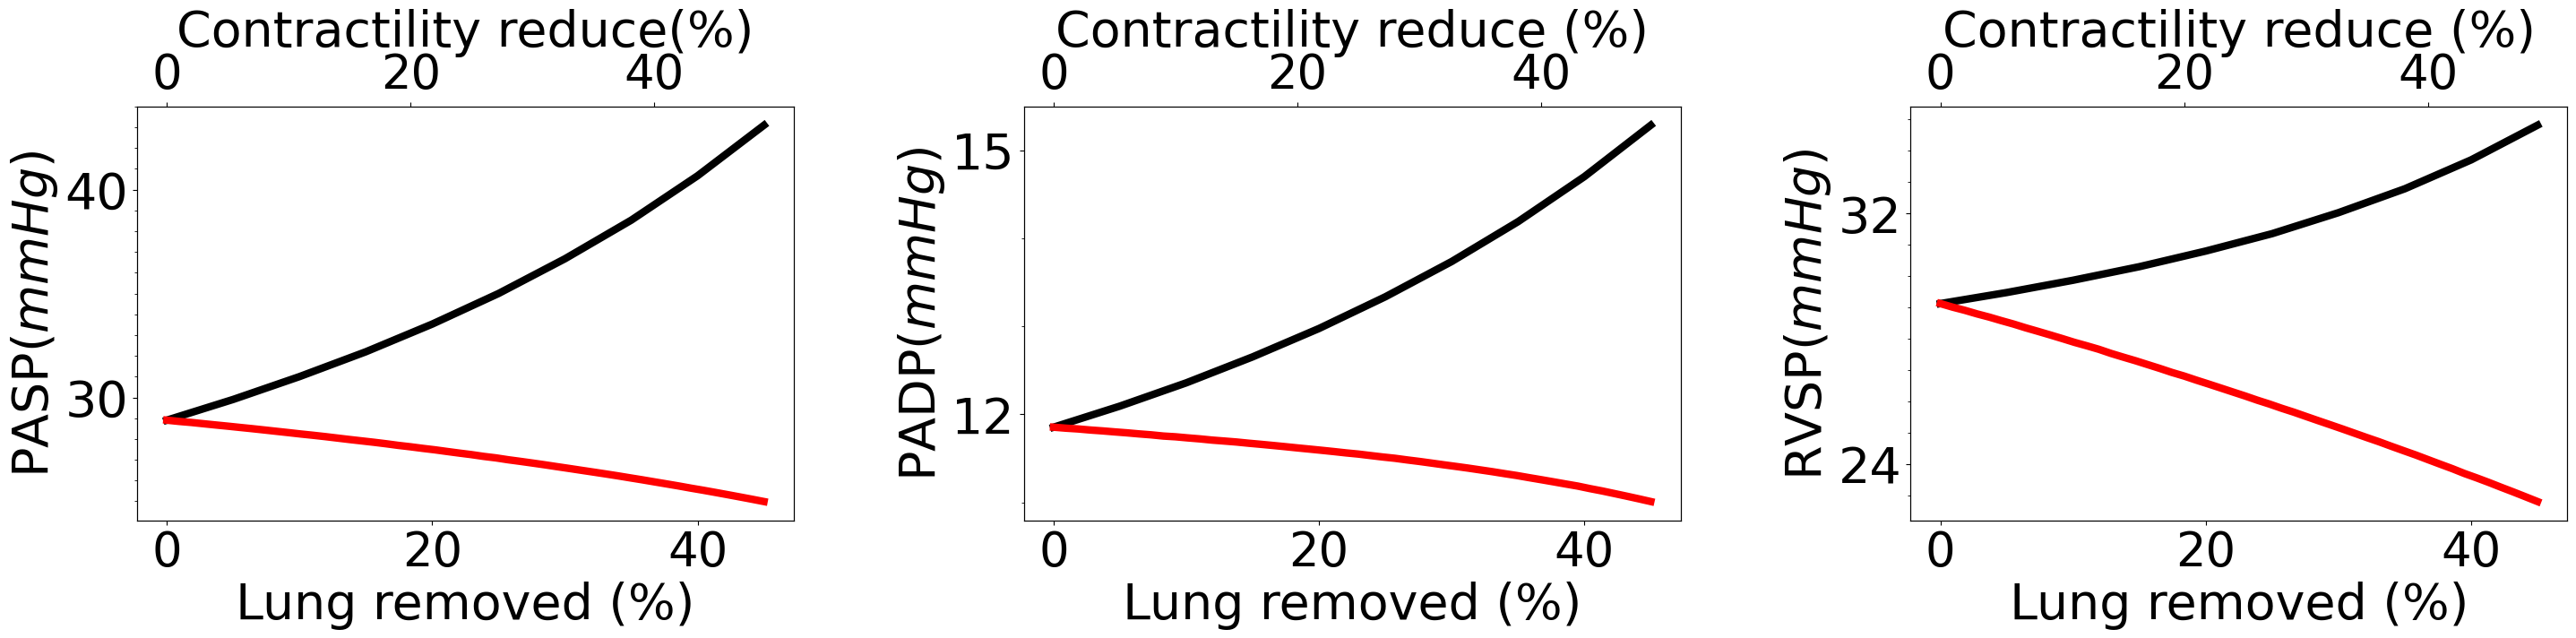

In [166]:
import matplotlib.ticker as ticker
xaxis = range(0,18)
labels = [str(i) for i in range(len(xaxis))]
fontsize = 40
fig, axs = plt.subplots(1, 3, figsize=(35, 6),sharex= True) 
label = ['sp', 'dp']
Label = ['SP', 'DP']
unit = ['$(mmHg)$', '$(mmHg)$']
axs[0].plot(rm, pasp_aft,linestyle='-', color = 'black', linewidth=6)
ax00 = axs[0].twiny()
ax00.plot(rate, pasp_con, linestyle='-',color = 'red', linewidth=6)
ax00.tick_params(axis = 'x', labelsize = fontsize - 2)
ax00.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
axs[0].set_ylabel(fr'PASP($mmHg$)', fontsize = fontsize)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].plot(rm, padp_aft,linestyle='-', color = 'black', linewidth = 6)
ax01 = axs[1].twiny()
ax01.plot(rate, padp_con, linestyle='-',color = 'red', linewidth = 6)
ax01.tick_params(axis = 'x', labelsize = fontsize - 2)
ax01.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
axs[1].set_ylabel(fr'PADP($mmHg$)', fontsize = fontsize)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[2].plot(rm, rvsp_aft,linestyle='-', label = 'Afterload', color = 'black', linewidth = 6)
ax02 = axs[2].twiny()
ax02.plot(rate, rvsp_con, linestyle='-',color = 'red', label = 'Contractility', linewidth = 6)
ax02.tick_params(axis = 'x', labelsize = fontsize - 2)
ax02.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
axs[2].set_ylabel(fr'RVSP($mmHg$)', fontsize = fontsize)
axs[2].xaxis.set_major_locator(MaxNLocator(integer=True))
for ax in axs.flat:
    ax.tick_params(axis = 'x', labelsize = fontsize - 2)
    ax.tick_params(axis = 'y', labelsize = fontsize)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=2,  integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=3, integer=True))
plt.subplots_adjust(wspace = 0.35)
plt.subplots_adjust(hspace = 0.55)
handles_0_0, labels_0_0 = axs[0].get_legend_handles_labels()
axs[0].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[1].set_xlabel('Lung removed (%)', fontsize = fontsize)
axs[2].set_xlabel('Lung removed (%)', fontsize = fontsize)
ax00.set_xlabel('Contractility reduce(%)', fontsize = fontsize)
ax01.set_xlabel('Contractility reduce (%)', fontsize = fontsize)
ax02.set_xlabel('Contractility reduce (%)', fontsize = fontsize)
plt.show()